In [ ]:
"""
! pip install imbalanced-learn
! pip install --upgrade scikit-learn imbalanced-learn
! pip install transformers datasets evaluate --quiet
! pip install transformers datasets --upgrade
! pip install --upgrade protobuf tiktoken
! pip install hf_xet
! pip install "accelerate>=0.26.0"
! pip install --upgrade transformers
"""
# ! pip install transformers datasets evaluate accelerate --upgrade
# ! pip install --upgrade --force-reinstall tokenizers protobuf regex numpy safetensors charset_normalizer




  Using cached tokenizers-0.21.2-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached regex-2024.11.6-cp310-cp310-win_amd64.whl.metadata (41 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached charset_normalizer-3.4.2-cp310-cp310-win_amd64.whl.metadata (36 kB)
  Using cached huggingface_hub-0.33.4-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Us

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.7.0 which is incompatible.


In [31]:
import notebook_setup
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments
from transformers import Trainer, EarlyStoppingCallback
from datasets import Dataset, DatasetDict

from collections import Counter

from utils.path_config import get_data_path
from utils.text_cleaning import clean_review_df
from utils.data_saving import save_with_rolling_backup
from utils.intent_mapping import apply_intent_mapping, inspect_potential_fp

#### Download and Cache Transformer Models (Preload)


In [ ]:
# Download and cache models and tokenizers
model_names = [
    "distilbert-base-uncased",
    "roberta-base",
    "microsoft/deberta-v3-small"

]

"""
for name in model_names:
    print(f"Downloading: {name}")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", force_download=True) # , force_download=True
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=8, force_download=True) # , force_download=True
print("All models and tokenizers cached locally.")
"""


Downloading: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading: microsoft/deberta-v3-small


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading: microsoft/mpnet-base


Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All models and tokenizers cached locally.


### Data import

In [38]:
df = pd.read_csv(get_data_path("chatbot_amazon_cleaned_v1.csv"))
df = apply_intent_mapping(df)

In [39]:
def merge_review_and_summary(row):
    review = str(row['reviewText']) if pd.notnull(row['reviewText']) else ""
    summary = str(row['summary']) if pd.notnull(row['summary']) else ""
    if review and summary:
        return f"{review.strip()}. {summary.strip()}"
    elif review:
        return review.strip()
    elif summary:
        return summary.strip()
    else:
        return ""

df['merged_text'] = df.apply(merge_review_and_summary, axis=1)

# Filter gold standard
gold_df = df[df['confidence_tag'] == "tier1_both"].copy()

# Set threshold: classes with < threshold samples become "OTHER"
rare_threshold = 11

# 1. Find rare classes automatically on full gold_df
class_counts = gold_df['intent_label'].value_counts()
rare_classes = class_counts[class_counts < rare_threshold].index.tolist()
print("Rare classes to merge into 'OTHER':", rare_classes)

# 2. Relabel rare classes everywhere in gold_df
gold_df['intent_label_clean'] = gold_df['intent_label'].apply(
    lambda x: "OTHER" if x in rare_classes else x
)
print('\nRare classes remapped to "OTHER" in intent_label_clean.')


Rare classes to merge into 'OTHER': ['PRODUCT_AVAILABILITY', 'TRACK_ORDER', 'FAQ_PAYMENT_METHODS', 'PRODUCT_EXPLAINABILITY', 'FAQ_SHIPPING_TIME', 'GENERIC_GREETING', 'REMOVE_FROM_CART']

Rare classes remapped to "OTHER" in intent_label_clean.


In [40]:
# Label Encoding intent labels
label_encoder = LabelEncoder()
gold_df['intent_label_encoded'] = label_encoder.fit_transform(gold_df['intent_label_clean'])
print(label_encoder.classes_)  # Save for decoding later

['CHECK_SALE_ITEMS' 'CONNECT_TO_AGENT' 'GOODBYE' 'OTHER' 'PRODUCT_SEARCH'
 'RETURN_ITEM' 'SENTIMENT_COMPLAINT' 'SENTIMENT_PRAISE'
 'VIEW_PRODUCT_DETAILS' 'VIEW_RECOMMENDATIONS']


In [41]:
other_encoded = list(label_encoder.classes_).index("OTHER")
print("Encoded value for 'OTHER':", other_encoded)

Encoded value for 'OTHER': 3


In [42]:
# Train, Test and validation split
X = gold_df['merged_text']
y = gold_df['intent_label_encoded']

# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15 / 0.85, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 1614, Val: 346, Test: 346


### Model 
#### Logistic Regression Tuned

In [7]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000,  # Adjust for memory/accuracy tradeoff
    ngram_range=(1,2)   # Unigrams and bigrams
)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)


In [8]:
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced'],
    'max_iter': [1000, 2000]
}

gs = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)
gs.fit(X_train_vec, y_train)
print("Best params:", gs.best_params_)

# Evaluate on val
best_lr = gs.best_estimator_
val_preds_gs = best_lr.predict(X_val_vec)
print(classification_report(y_val, val_preds_gs, target_names=label_encoder.classes_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
                      precision    recall  f1-score   support

    CHECK_SALE_ITEMS       0.89      0.80      0.84        10
    CONNECT_TO_AGENT       1.00      0.78      0.88         9
             GOODBYE       1.00      1.00      1.00         7
               OTHER       1.00      0.67      0.80         3
      PRODUCT_SEARCH       0.94      0.96      0.95       140
         RETURN_ITEM       1.00      1.00      1.00        15
 SENTIMENT_COMPLAINT       0.91      0.95      0.93        22
    SENTIMENT_PRAISE       0.97      0.97      0.97       116
VIEW_PRODUCT_DETAILS       0.50      0.75      0.60         4
VIEW_RECOMMENDATIONS       1.00      1.00      1.00        20

            accuracy                           0.95       346
           macro avg       0.92      0.89      0.90       346
        weighted avg     

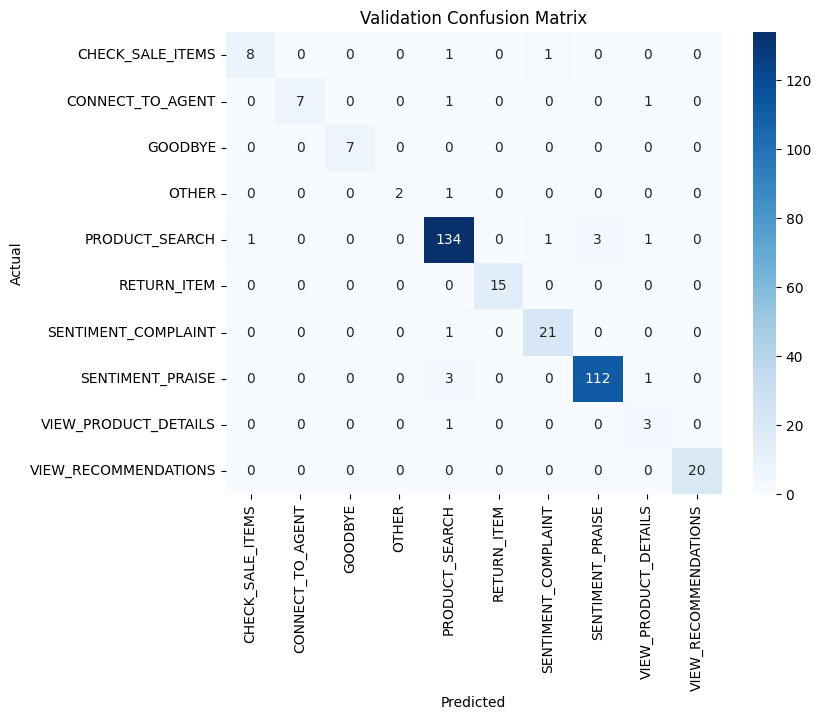

In [9]:
cm = confusion_matrix(y_val, val_preds_gs)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

#### Phase 3: Transformer-Based Intent Classifier


In [ ]:
# ================================================
# 
# ================================================

In [11]:
# ------------------------------------------------
# 1. Load DistilBERT Tokenizer and Model
# ------------------------------------------------

# Choose base model name (can be reused for other models later)
tokenizer_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Tokenization function for Hugging Face Datasets
def tokenize_function(example):
    return tokenizer(
        example["merged_text"],
        padding="max_length",    # Pad all to same length (required for batching)
        truncation=True,         # Truncate long reviews to max_length
        max_length=128           # Safe default; we can tune this later
    )

In [12]:
# ------------------------------------------------
# 2. Convert Train / Val / Test into Hugging Face DatasetDict
# ------------------------------------------------

# Combine text and label into new dataframes
train_df = pd.DataFrame({"merged_text": X_train, "label": y_train})
val_df   = pd.DataFrame({"merged_text": X_val, "label": y_val})
test_df  = pd.DataFrame({"merged_text": X_test, "label": y_test})

# Create Hugging Face Datasets
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})


In [ ]:
# ------------------------------------------------
# 3. Tokenize and Format Datasets
# ------------------------------------------------

# Apply tokenizer to each split using batching
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Set format for PyTorch (input_ids, attention_mask, and label required by Trainer)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Set train, validation, and test datasets
train_dataset = tokenized_datasets["train"]
val_dataset   = tokenized_datasets["validation"]
test_dataset  = tokenized_datasets["test"]

Map:   0%|          | 0/1614 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

In [ ]:
# ------------------------------------------------
# 4. Define TrainingArguments and Load DistilBERT Model
# ------------------------------------------------


# Load DistilBERT model with number of labels based on label encoder
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(tokenizer_name, num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./models/distilbert-intent",         # Where to save model checkpoints
    eval_strategy="epoch",                     # Run eval at the end of each epoch
    save_strategy="epoch",                           # Save model after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,                     # Reduced for faster training and optimal performance
    weight_decay=0.01,
    logging_dir="./logs/distilbert",                 # Where to store logs
    load_best_model_at_end=True,                     # Retain best based on eval loss
    metric_for_best_model="f1",                      # We'll define this later
    greater_is_better=True                           # F1 should be maximized
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --------------------------------------------
# 5. Define compute_metrics for Evaluation
# --------------------------------------------



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
    }


In [21]:
# ------------------------------------------------
# 6. Create Trainer and Train the Model
# ------------------------------------------------

"""
train_dataset = tokenized_datasets["train"]
val_dataset   = tokenized_datasets["validation"]
test_dataset  = tokenized_datasets["test"] 
"""
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,                 # Optional but helpful for logging
    compute_metrics=compute_metrics
)
trainer.train()

C:\Users\abhay\AppData\Local\Temp\ipykernel_7884\3778399457.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.626643,0.869942,0.429382,0.410509,0.454416
2,No log,0.256274,0.953757,0.738132,0.731796,0.746645
3,No log,0.173505,0.953757,0.799302,0.825452,0.791385
4,No log,0.136436,0.965318,0.849339,0.839801,0.861385
5,0.405900,0.121884,0.965318,0.888307,0.891229,0.890173
6,0.405900,0.122740,0.971098,0.898197,0.896429,0.900887
7,0.405900,0.114049,0.971098,0.897857,0.893172,0.904719
8,0.405900,0.115950,0.971098,0.897857,0.893172,0.904719


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

TrainOutput(global_step=808, training_loss=0.2625322932063943, metrics={'train_runtime': 5403.4928, 'train_samples_per_second': 2.39, 'train_steps_per_second': 0.15, 'total_flos': 427665768652800.0, 'train_loss': 0.2625322932063943, 'epoch': 8.0})

c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report (Test Set):
                      precision    recall  f1-score   support

    CHECK_SALE_ITEMS       0.82      0.90      0.86        10
    CONNECT_TO_AGENT       1.00      1.00      1.00         9
             GOODBYE       1.00      0.71      0.83         7
               OTHER       0.50      0.33      0.40         3
      PRODUCT_SEARCH       0.98      0.99      0.98       140
         RETURN_ITEM       1.00      1.00      1.00        15
 SENTIMENT_COMPLAINT       1.00      0.91      0.95        22
    SENTIMENT_PRAISE       0.98      0.99      0.99       116
VIEW_PRODUCT_DETAILS       0.60      0.75      0.67         4
VIEW_RECOMMENDATIONS       0.95      1.00      0.98        20

            accuracy                           0.97       346
           macro avg       0.88      0.86      0.87       346
        weighted avg       0.97      0.97      0.97       346



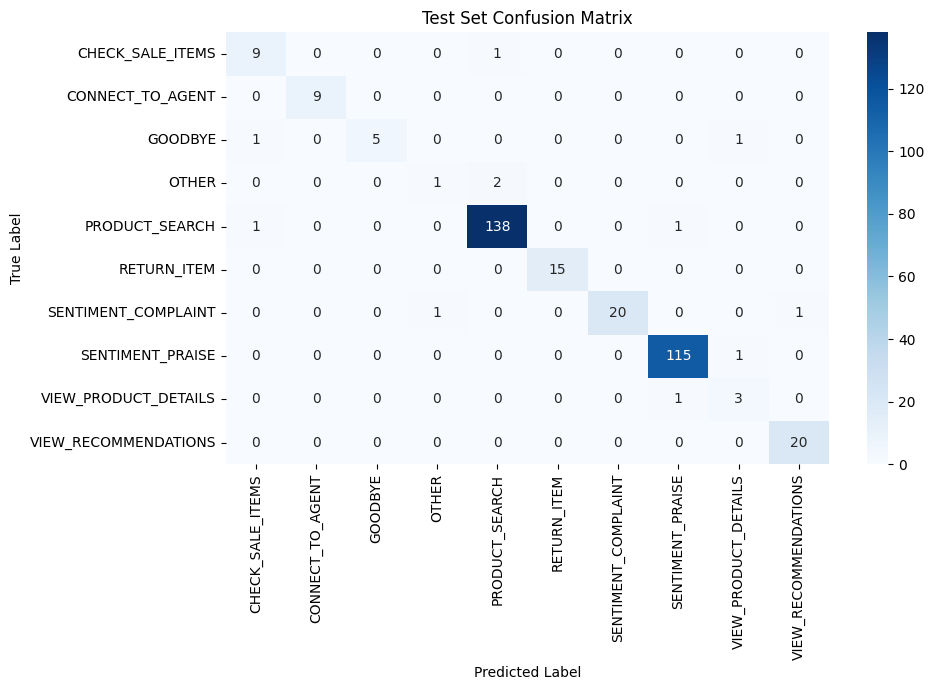

In [22]:
# ------------------------------------------------
# 7. Evaluate Trained Model on Test Set
# ------------------------------------------------

# Make predictions
test_results = trainer.predict(test_dataset)

# Extract predictions and labels
preds = np.argmax(test_results.predictions, axis=1)
true  = test_results.label_ids

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(true, preds, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(true, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.show()


In [24]:
# Predict on test set
preds_output = trainer.predict(tokenized_datasets["test"])
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=1)

# Convert numeric labels to original intent strings
true_intents = label_encoder.inverse_transform(y_true)
predicted_intents = label_encoder.inverse_transform(y_pred)


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [27]:
from collections import Counter
import pandas as pd

# Count how many times each intent appears in the test set
intent_counts = Counter(true_intents)

# Convert to DataFrame for easier viewing
intent_freq_df = pd.DataFrame.from_dict(intent_counts, orient="index", columns=["Count"])
intent_freq_df = intent_freq_df.sort_values("Count", ascending=False)

intent_freq_df.head(10)



,Count
PRODUCT_SEARCH,140
SENTIMENT_PRAISE,116
SENTIMENT_COMPLAINT,22
VIEW_RECOMMENDATIONS,20
RETURN_ITEM,15
CHECK_SALE_ITEMS,10
CONNECT_TO_AGENT,9
GOODBYE,7
VIEW_PRODUCT_DETAILS,4
OTHER,3


In [28]:
# Re-tokenize after updating raw_datasets["train"]
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/1614 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

## Phase 3 Summary – DistilBERT Training + VIEW_PRODUCT_DETAILS Fix

- Trained `distilbert-base-uncased` model using tokenized HF dataset
- Achieved performance:
  - Weighted F1: 0.97
  - Macro F1: 0.87
  - Accuracy: ~97%
- Identified low-performing intent: `VIEW_PRODUCT_DETAILS`
- Applied improvements:
  - Added 15 synthetic training examples (diverse, intent-specific)
  - Re-tokenized dataset to include new samples
  - Updated `intent_keywords` for runtime disambiguation support
  - Flagged fallback logic as a future safety net (Phase 4)

## Phase 3.1 – RoBERTa Training (Next)

**Goal**: Train `roberta-base` on the improved dataset  
**Key features**:
- More context-aware embedding model (vs. DistilBERT)
- Uses same tokenizer format with better linguistic modeling

**To do**:
- Load tokenizer & model for `roberta-base`
- Use dynamic `TrainingArguments` (custom batch size, epochs)
- Apply early stopping manually via metric trends
- Evaluate & log results (accuracy, F1, confusion matrix)


In [43]:
# Convert pandas splits to Hugging Face Datasets
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(pd.DataFrame({"merged_text": X_train, "label": y_train})),
    "validation": Dataset.from_pandas(pd.DataFrame({"merged_text": X_val, "label": y_val})),
    "test": Dataset.from_pandas(pd.DataFrame({"merged_text": X_test, "label": y_test}))
})

# Tokenize all splits
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    load_from_cache_file=False  # Forces tokenization to run fresh
)

# Format for PyTorch
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1614 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

In [44]:
# Define model name
model_name = "roberta-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define number of labels based on the same label encoder used earlier
num_labels = len(label_encoder.classes_)

# Load model with correct number of output classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from transformers import TrainingArguments

# Dynamic settings specific to RoBERTa
model_output_dir = f"./models/{model_name.replace('/', '_')}"
log_dir = f"./logs/{model_name.replace('/', '_')}"

training_args = TrainingArguments(
    output_dir=model_output_dir,
    eval_strategy="epoch",               # Evaluate every epoch
    save_strategy="epoch",                     # Save checkpoint every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,            # Lower batch size for heavier model
    per_device_eval_batch_size=32,
    num_train_epochs=8,                        # early-stopping applied
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir=log_dir,
    logging_steps=20,
    save_total_limit=2                         # Save space
)


In [46]:
# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [47]:
# Begin training
trainer.train()

# After training completes, print the best model path

print("\n\n---------------------------------------------------------------------------------------")

print(f"\nTraining complete for model: {model_name}")
print("\nBest checkpoint path:", trainer.state.best_model_checkpoint)
print(f"Stopped at epoch: {trainer.state.epoch:.1f}")


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.671100,0.505122,0.875723,0.845038,0.828074,0.875723
2,0.203500,0.136108,0.968208,0.965928,0.965247,0.968208
3,0.096100,0.115699,0.971098,0.967820,0.965607,0.971098
4,0.020300,0.036993,0.988439,0.987259,0.989540,0.988439
5,0.022000,0.040728,0.991329,0.991208,0.992118,0.991329
6,0.006200,0.039847,0.988439,0.988691,0.989543,0.988439
7,0.005300,0.044110,0.988439,0.988463,0.989806,0.988439


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhay\AppData\Local\Programs\Python\



---------------------------------------------------------------------------------------

Training complete for model: roberta-base

Best checkpoint path: ./models/roberta-base\checkpoint-505
Stopped at epoch: 7.0


In [48]:
# Reload best checkpoint (just in case)
from transformers import AutoModelForSequenceClassification

best_model_path = trainer.state.best_model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=num_labels)
trainer.model = model

# Evaluate on test set
test_metrics = trainer.evaluate(tokenized_datasets["test"])
print("Test set metrics (RoBERTa):")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test set metrics (RoBERTa):
eval_loss: 0.2103
eval_accuracy: 0.9682
eval_f1: 0.9673
eval_precision: 0.9680
eval_recall: 0.9682
eval_runtime: 91.5973
eval_samples_per_second: 3.7770
eval_steps_per_second: 0.1200
epoch: 7.0000


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report (RoBERTa):
                      precision    recall  f1-score   support

    CHECK_SALE_ITEMS       1.00      1.00      1.00        10
    CONNECT_TO_AGENT       1.00      1.00      1.00         9
             GOODBYE       1.00      0.71      0.83         7
               OTHER       0.67      0.67      0.67         3
      PRODUCT_SEARCH       0.99      0.97      0.98       140
         RETURN_ITEM       1.00      1.00      1.00        15
 SENTIMENT_COMPLAINT       0.95      0.95      0.95        22
    SENTIMENT_PRAISE       0.97      0.99      0.98       116
VIEW_PRODUCT_DETAILS       0.67      0.50      0.57         4
VIEW_RECOMMENDATIONS       0.91      1.00      0.95        20

            accuracy                           0.97       346
           macro avg       0.91      0.88      0.89       346
        weighted avg       0.97      0.97      0.97       346



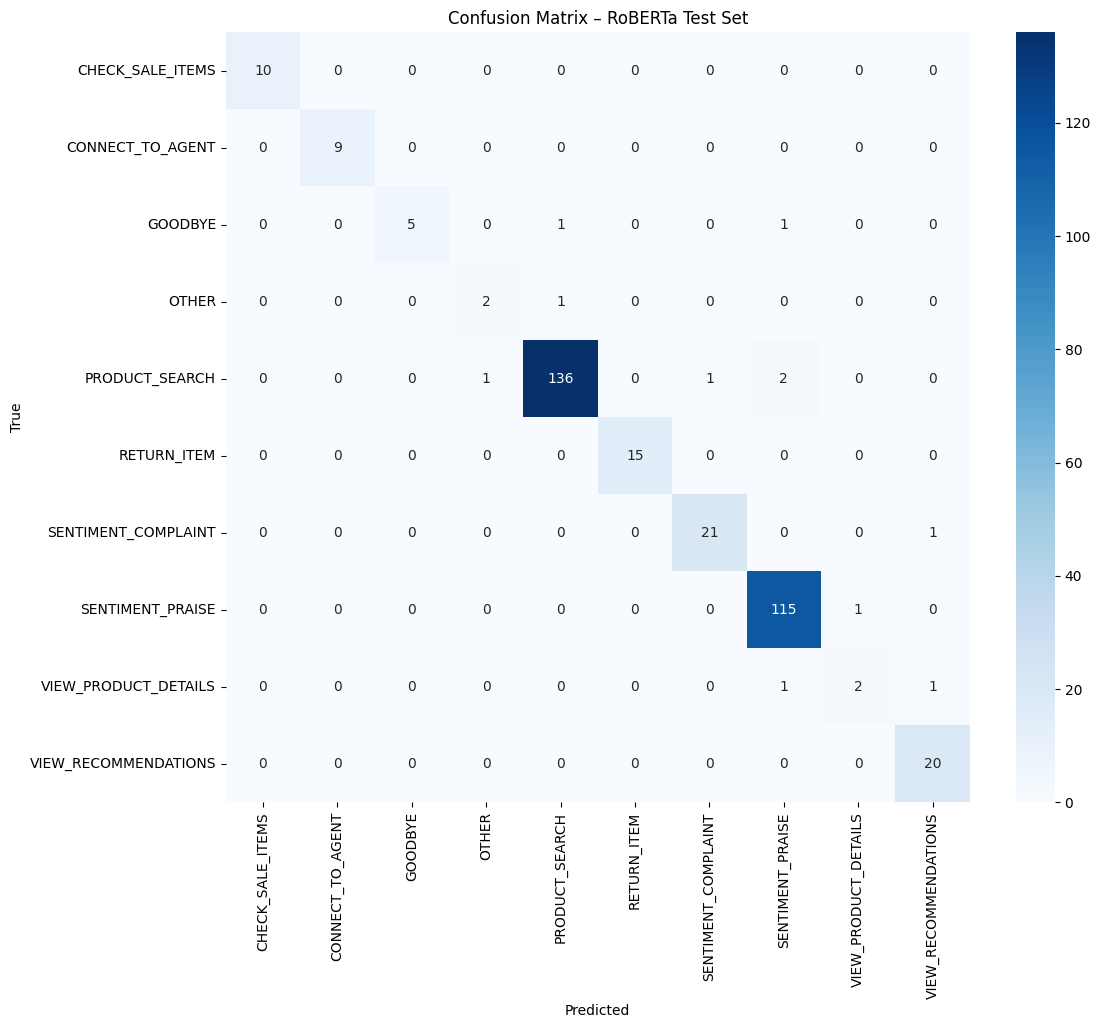

In [49]:
# Predict again using RoBERTa on test set
preds_output = trainer.predict(tokenized_datasets["test"])
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=1)

# Decode to intent strings
true_intents = label_encoder.inverse_transform(y_true)
predicted_intents = label_encoder.inverse_transform(y_pred)

# Classification report
print("Classification Report (RoBERTa):")
print(classification_report(true_intents, predicted_intents, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(true_intents, predicted_intents, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – RoBERTa Test Set")
plt.show()
